In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def Create_folds(data, k=3):
    Group_1 , Group_2 = np.split(data, np.where(np.diff(data[:,-1]))[0]+1)
    res = list()
    Parts_1 = np.array_split(Group_1, k)
    Parts_2 = np.array_split(Group_2, k)
    for i in range(k):
        temp = np.concatenate((Parts_1[i],Parts_2[i]))
        np.random.shuffle(temp)
        res.append(temp)
    return res

def Normalizar_Datos( arraynp ):
    last = np.array(arraynp[:,-1])
    mean = np.mean(arraynp,0)
    standard = np.std(arraynp,0)
    for i in range(0,arraynp.shape[0]):
        arraynp[i] = np.true_divide((arraynp[i] - mean), standard)
    arraynp[:,-1] = last[:]
    return arraynp

def Leer_Datos( name, delmt = '\t',head = None, col=""):
    data = pd.read_csv(name,delimiter = delmt, header = head, dtype = np.float64)
    data = data.sort_values(by=[col])
    return Normalizar_Datos(data.values)

def Leer_Datos_num(name, delmt = '\t',head = None):
    data = pd.read_csv(name,delimiter = delmt, header = head, dtype = np.float64)
    return data.values

In [3]:
def Get_Train_Test(folds, tt, k=3):
    train = np.array([])
    test = np.array([])
    for i in range(k):
        if i in tt:
            if len(test) == 0:
                test = folds[i]
            else:
                test = np.concatenate((test,folds[i]))
        else:
            if len(train) == 0:
                train = folds[i]
            else:
                train = np.concatenate((train,folds[i]))
    return train, test

def Save_Folds(folds, name,file='/',delt='\t'):
    for i in range(len(folds)):
        tname = file + name + '_' + str(i+1) + '.csv'
        np.savetxt(tname, folds[i], delimiter='\t')
        
def Get_Folds(name, delmt='\t', k=3):
    name = 'folds/' + name + '_'
    folds = list()
    for i in range(k):
        dt = Leer_Datos_num(name+str(i+1)+'.csv', delmt=delmt)
        folds.append(dt)
    return folds

In [4]:
folds_D = Create_folds(Leer_Datos("Conjuntos_raw/diabetes.csv",delmt='\t',head=0,col='Outcome'))
folds_C = Create_folds(Leer_Datos("Conjuntos_raw/Enfermedad_Cardiaca.csv",delmt='\t',head=0,col='target'))
print('diabetes', folds_D[0].shape, folds_D[1].shape, folds_D[2].shape)
print('Enfermedad_Cardiaca', folds_C[0].shape, folds_C[1].shape, folds_C[2].shape)

Save_Folds(folds_C,'Enfermedad_Cardiaca','folds/')
Save_Folds(folds_D,'Diabetes','folds/')

diabetes (257, 9) (256, 9) (255, 9)
Enfermedad_Cardiaca (101, 14) (101, 14) (101, 14)


In [5]:
def Sigmoidal(X,Theta):
    h = X.dot(Theta.T)
    z = 1/(1 + np.exp(-h))
    return z

def Calcular_Costo(X, Y, Theta):
    m = len(X)
    h = Sigmoidal(X,Theta)
    a = np.log(h) * Y
    b = np.log(1-h) * (1-Y)
    cost = np.sum(a + b)*(-1/ m)
    return cost

def Gradiente_Descendiente(X, Y, Theta, iteraciones, tasa):
    costos = [0]*iteraciones
    m = len(X)
    for itr in range(iteraciones):
        h = Sigmoidal(X,Theta)
        dif = h - Y
        derivada = (X.T).dot(dif) / m
        Theta = Theta - (tasa * derivada).T
        costos[itr] = Calcular_Costo(X, Y, Theta)
    return Theta, costos

In [6]:
def Calcular_Accuracy(X, Y, Theta):
    y_predict = Sigmoidal(X, Theta).round()#np.rint(Sigmoidal(X, Theta))
    count = 0
    for v in (Y-y_predict):
        if(v == 0):
            count = count + 1
    return (count/len(Y)) * 100

In [7]:
def Adapt_sets(test_set, train_set):
    test_y = test_set[:,-1:]
    test_x = test_set[:,0:-1]
    train_y = train_set[:,-1:]
    train_x = train_set[:,0:-1]
    
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    
    return train_x, train_y, test_x, test_y

In [8]:
D_folds = Get_Folds('Diabetes')
C_folds = Get_Folds('Enfermedad_Cardiaca')

In [10]:
##  Experimento 1 (1)

iteraciones = [500, 1000, 1500, 2000, 2500, 3000, 3500]
tasa_aprendizaje = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
K = 3

matrix_ac = np.random.rand(len(tasa_aprendizaje),len(iteraciones),3)
parametros = (0,0)
for k in range(K):
    D_train, D_test = Get_Train_Test(D_folds,[k])
    D_train_x, D_train_y, D_test_x, D_test_y = Adapt_sets(D_test,D_train)
    D_Theta = np.zeros(D_train_x.shape[1])[np.newaxis]
    
    for ta in  range(len(tasa_aprendizaje)):
        for itr in range(len(iteraciones)):
            cur_Theta, _ = Gradiente_Descendiente(D_train_x, D_train_y, D_Theta, iteraciones[itr], tasa_aprendizaje[ta])
            matrix_ac[ta,itr,k] = Calcular_Accuracy(D_test_x, D_test_y, cur_Theta)

matrix_ac = np.mean(matrix_ac,axis=2)
for ta in  range(len(tasa_aprendizaje)):
    for itr in range(len(iteraciones)):
        if(matrix_ac[ta,itr] > matrix_ac[parametros[0],parametros[1]]):
            parametros = (ta, itr)

df1 = pd.DataFrame(data = matrix_ac, index= tasa_aprendizaje, columns = iteraciones)
print("Mayor accuracy promedio con:",tasa_aprendizaje[parametros[0]],iteraciones[parametros[1]])
df1

Mayor accuracy promedio con: 0.01 3000


,500,1000,1500,2000,2500,3000,3500
0.01,76.162477,76.031758,76.683314,77.204654,77.073936,77.333846,77.204144
0.05,77.204144,77.205161,77.074953,77.205672,77.205672,77.205672,77.205672
0.10,77.205161,77.205672,77.205672,77.205672,77.205672,77.205672,77.205672
0.20,77.205672,77.205672,77.205672,77.205672,77.205672,77.205672,77.205672
0.30,77.205672,77.205672,77.205672,77.205672,77.205672,77.205672,77.205672
0.40,77.205672,77.205672,77.205672,77.205672,77.205672,77.205672,77.205672


Text(0.5, 1.0, 'Diabetes Dataset')

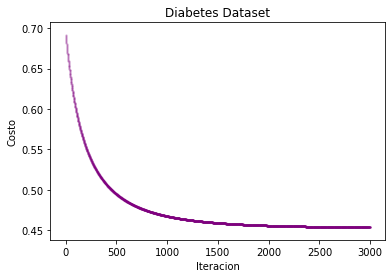

In [11]:
##  Experimento 2 (1)

_, costos = Gradiente_Descendiente(D_train_x, D_train_y, D_Theta, iteraciones[parametros[1]], tasa_aprendizaje[parametros[0]])
plt.scatter(np.arange(iteraciones[parametros[1]]),costos,alpha=0.2, c="purple", s=2)
plt.xlabel('Iteracion')
plt.ylabel('Costo')
plt.title('Diabetes Dataset')

In [12]:
##  Experimento 1 (2)

matrix_ac = np.random.rand(len(tasa_aprendizaje),len(iteraciones),3)
parametros = (0,0)
for k in range(K):
    C_train, C_test = Get_Train_Test(C_folds,[k])
    C_train_x, C_train_y, C_test_x, C_test_y = Adapt_sets(C_test,C_train)
    C_Theta = np.zeros(C_train_x.shape[1])[np.newaxis]
    
    for ta in  range(len(tasa_aprendizaje)):
        for itr in range(len(iteraciones)):
            cur_Theta, _ = Gradiente_Descendiente(C_train_x, C_train_y, C_Theta, iteraciones[itr], tasa_aprendizaje[ta])
            matrix_ac[ta,itr,k] = Calcular_Accuracy(C_test_x, C_test_y, cur_Theta)

matrix_ac = np.mean(matrix_ac,axis=2)
for ta in  range(len(tasa_aprendizaje)):
    for itr in range(len(iteraciones)):
        if(matrix_ac[ta,itr] > matrix_ac[parametros[0],parametros[1]]):
            parametros = (ta, itr)

df2 = pd.DataFrame(data = matrix_ac, index= tasa_aprendizaje, columns = iteraciones)
print("Mayor accuracy promedio con:",tasa_aprendizaje[parametros[0]],iteraciones[parametros[1]])
df2

Mayor accuracy promedio con: 0.01 2000


,500,1000,1500,2000,2500,3000,3500
0.01,83.498350,82.838284,83.168317,84.158416,84.158416,83.828383,83.828383
0.05,84.158416,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383
0.10,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383
0.20,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383
0.30,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383
0.40,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383,83.828383


Text(0.5, 1.0, 'Enfermedad Cardiaca Dataset')

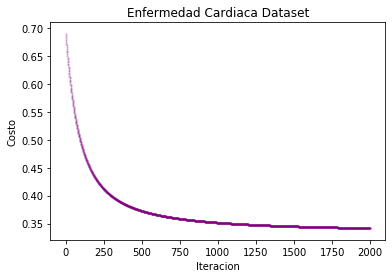

In [13]:
##  Experimento 2 (2)

_, costos = Gradiente_Descendiente(C_train_x, C_train_y, C_Theta, iteraciones[parametros[1]], tasa_aprendizaje[parametros[0]])
plt.scatter(np.arange(iteraciones[parametros[1]]),costos,alpha=0.2, c="purple", s=2)
plt.xlabel('Iteracion')
plt.ylabel('Costo')
plt.title('Enfermedad Cardiaca Dataset')